In [1]:
%load_ext autoreload
import torch
import torchcfm
import sys
import gen_model_playground
from gen_model_playground.fit.vae import VAE
from gen_model_playground.fit.gan import GAN
from gen_model_playground.fit.flow import Flow
from gen_model_playground.fit.flow_matching import FM
from gen_model_playground.fit.ddpm import DDPM
from gen_model_playground.models.model import Model
import matplotlib.pyplot as plt
import numpy as np
from my_cmaps import cmap
from gen_model_playground.data.twomoons import TwoMoonsDataModule
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import numpy as np
import os
device="cuda" if torch.cuda.is_available() else "cpu"


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

In [2]:
vae=VAE.load_from_checkpoint("../ckpts/vae.ckpt")

nsgan=GAN.load_from_checkpoint("../ckpts/NSGAN.ckpt")

flow=Flow.load_from_checkpoint("../ckpts/RQS.ckpt")

exact=FM.load_from_checkpoint("../ckpts/exact.ckpt")
names=["VAE","NSGAN","RQS","Exact"]
models=[vae,nsgan,flow,exact]

In [13]:
os.makedirs("../gen_model_playground/plots/eval",exist_ok=True)

def train_and_eval_classifier(gen_model,name):

    loss=torch.nn.BCEWithLogitsLoss()
    classifier=Model(2,1,hidden_features=16,dropout=0.0, bias=True, num_blocks=16,batch_norm=True).to(device)
    batch_size=1000
    data_module=TwoMoonsDataModule(batch_size=batch_size,num_batches=100)
    model=gen_model
    losses=[]
    sanity=False
    opt=torch.optim.AdamW(classifier.parameters(),lr=1e-3)
    for k in range(15):
        for i,x in enumerate(data_module.train_dataloader()):
            with torch.no_grad():

                model=model.to(device)
                z=torch.randn(batch_size, model.hparams.in_features).to(device)
                xhat=model.sample(z) if not sanity else torch.randn_like(xhat)
            x=torch.cat([x[0].to(device),xhat])
            labels=torch.cat([torch.ones(len(xhat)).to(device),torch.zeros(len(xhat)).to(device)])

            opt.zero_grad()
            d_loss=loss(classifier(x),labels.unsqueeze(1))
            d_loss.backward()
            losses.append(d_loss.item())
            opt.step()
        if k%10==1:
                print(d_loss.item())
        plt.plot(losses)
    plt.show()
    classifier.eval()
    n_eval=100000
    # Get the predicted probabilities from the classifier

    # Generate fake data
    with torch.no_grad():
        model = model.to(device)
        z = torch.randn(n_eval, model.hparams.in_features).to(device)
        xhat=model.sample(z) if not sanity else torch.randn_like(xhat)

        # Assuming model.sample() generates samples itself, replace 'z' accordingly
        fake_scores = torch.nn.functional.sigmoid(classifier(xhat)).squeeze().cpu().numpy()

        # Get real data scores
        x = data_module.train_dataloader().dataset.tensors[0][:n_eval]
        real_scores = torch.nn.functional.sigmoid(classifier(x.to(device))).squeeze().cpu().numpy()

        # Combine labels and scores
        labels = np.concatenate([np.zeros(n_eval), np.ones(n_eval)])
        scores = np.concatenate([fake_scores, real_scores])

        # Compute ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(labels, scores)
        auc_score = roc_auc_score(labels, scores)
        plt.close()
        # Plot ROC curve
        plt.figure(figsize=(6.2,6.2))

        plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal dashed line
        plt.xlabel('False Positive Rate',fontsize=20)
        plt.ylabel('True Positive Rate',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc='lower right')
        plt.tight_layout()

        plt.savefig("../gen_model_playground/plots/eval/roc_{}.pdf".format(name))
        plt.show()

        reversed=True if auc_score<0.5 else False
        classifier.eval()
        q=0.05
        with torch.no_grad():
            model=model.to(device)
            z=torch.randn(100000, model.hparams.in_features).to(device)
            xhat=model.sample(z)
            scores=torch.nn.functional.sigmoid(classifier(xhat)).squeeze()
            weights=scores/(1-scores+1e-8) if not reversed else (1-scores)/(scores+1e-8)


        lower,upper=weights.kthvalue(int(q*len(weights)),dim=0)[0],weights.kthvalue(int((1-q)*len(weights)),dim=0)[0]

        reals=data_module.dataset.tensors[0][:100000]
        plt.figure(figsize=(6.2,6.2))
        n,_,_=plt.hist(weights.cpu().numpy(),bins=np.logspace(weights.quantile(0.005).log().item(),weights.quantile(1-0.005).log().item(),100))
        print(lower,upper)
        plt.xscale("log")
        plt.xscale("log")
        plt.vlines(lower.item(),0,max(n),label="lower",color=plt.cm.get_cmap()(0.1))
        plt.vlines(upper.item(),0,max(n),label="upper",color=plt.cm.get_cmap()(0.1))
        plt.xlim(weights.quantile(0.005).item(),weights.quantile(1-0.005).item())
        plt.xlabel(r"$w$",fontsize=20)
        plt.ylabel("Count",fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.tight_layout()
        plt.savefig("../gen_model_playground/plots/eval/{}_weights.pdf".format(name))
        plt.show()
                # lower,upper=0.8, 1.2
        x_lower=xhat[weights<lower]
        x_upper=xhat[weights>upper]


        cmap = LinearSegmentedColormap.from_list("", ["white", *plt.cm.Blues(np.arange(255))])
        fig,ax=plt.subplots(1,2,figsize=(12.4,6.2))
        _,xx,yy,_=ax[1].hist2d(reals[:,0].cpu().numpy(),reals[:,1].cpu().numpy(),cmap=cmap, bins=100, )
        ax[0].hist2d(xhat[:,0].cpu().numpy(),xhat[:,1].cpu().numpy(),cmap=cmap,bins=(xx,yy), )
        ax[0].scatter(x_lower[:,0].cpu().numpy(),x_lower[:,1].cpu().numpy(),s=1,label="overrepresented w<{:.2f}".format(lower),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))


        ax[1].scatter(x_upper[:,0].cpu().numpy(),x_upper[:,1].cpu().numpy(),s=1, label="underrepresented w>{:.2f}".format(upper),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))
        ax[0].set_xlim(xx.min(),xx.max())
        ax[0].set_ylim(yy.min(),yy.max())
        ax[0].axis("off")
        ax[1].axis("off")
        import os
        plt.savefig("../gen_model_playground/plots/eval/{}_over_under.pdf".format(name))
        plt.show()

0.1431611031293869
0.11400284618139267


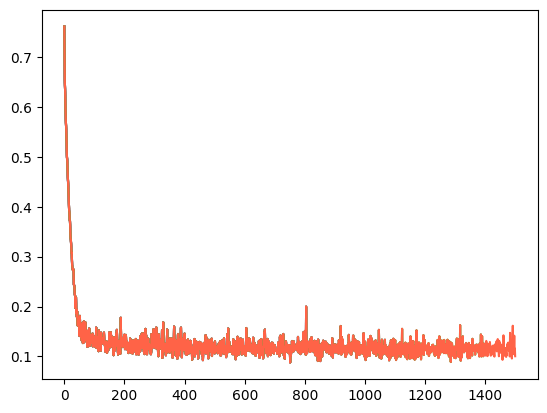

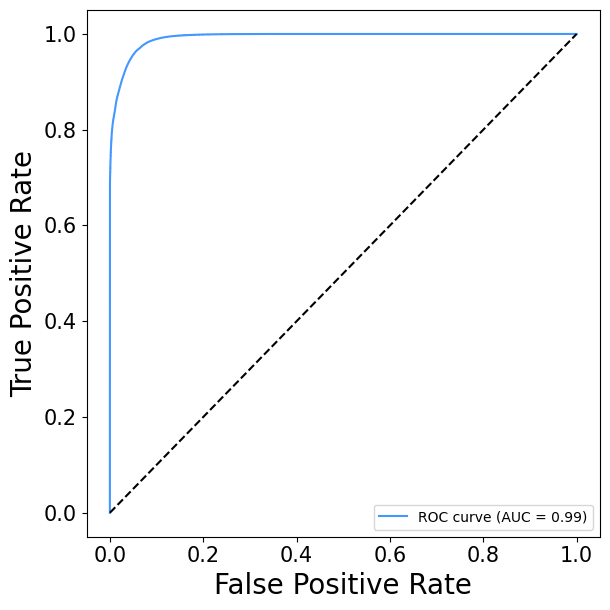

tensor(2.7160e-05, device='cuda:0') tensor(1.4681, device='cuda:0')


/tmp/ipykernel_32010/2166798665.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(lower.item(),0,max(n),label="lower",color=plt.cm.get_cmap()(0.1))
/tmp/ipykernel_32010/2166798665.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(upper.item(),0,max(n),label="upper",color=plt.cm.get_cmap()(0.1))


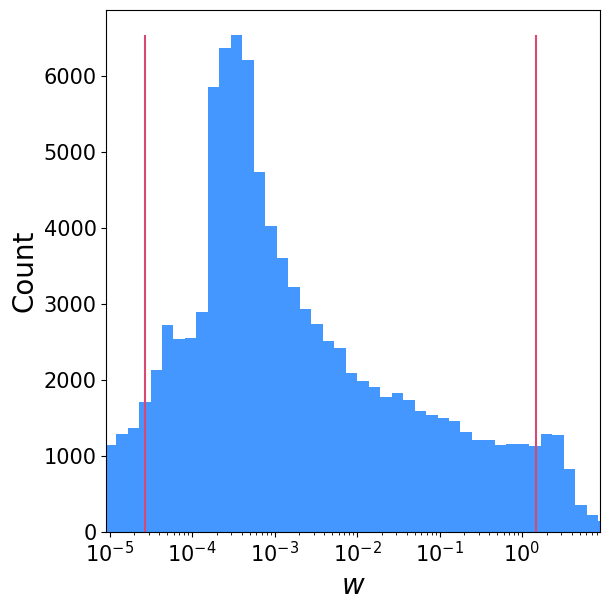

/tmp/ipykernel_32010/2166798665.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x_lower[:,0].cpu().numpy(),x_lower[:,1].cpu().numpy(),s=1,label="overrepresented w<{:.2f}".format(lower),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))
/tmp/ipykernel_32010/2166798665.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x_upper[:,0].cpu().numpy(),x_upper[:,1].cpu().numpy(),s=1, label="underrepresented w>{:.2f}".format(upper),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))


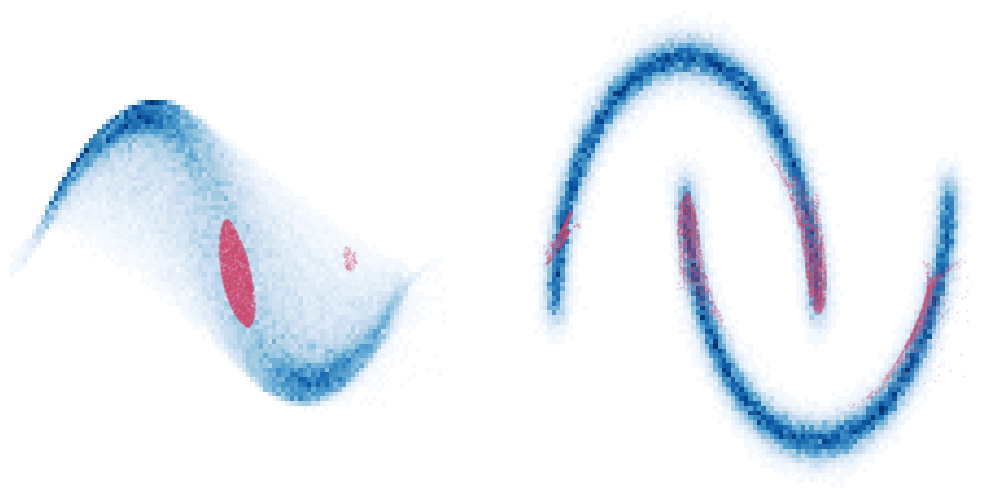

0.6799143552780151
0.6520472764968872


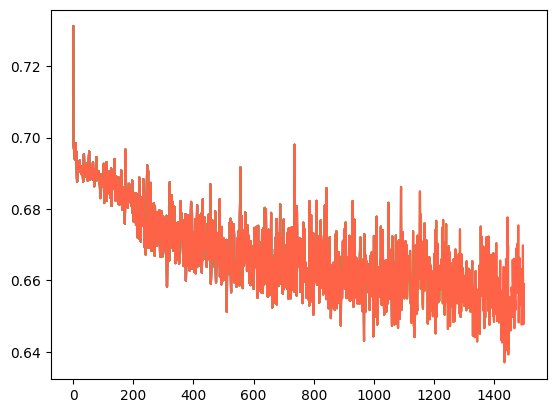

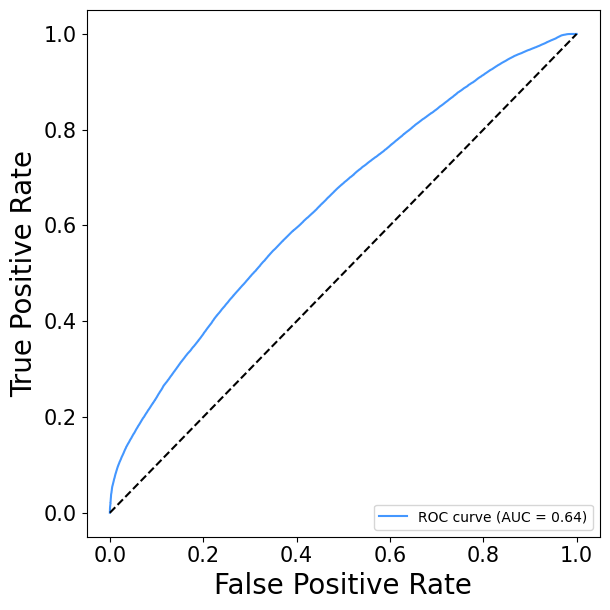

tensor(0.3511, device='cuda:0') tensor(1.5538, device='cuda:0')


/tmp/ipykernel_32010/2166798665.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(lower.item(),0,max(n),label="lower",color=plt.cm.get_cmap()(0.1))
/tmp/ipykernel_32010/2166798665.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(upper.item(),0,max(n),label="upper",color=plt.cm.get_cmap()(0.1))


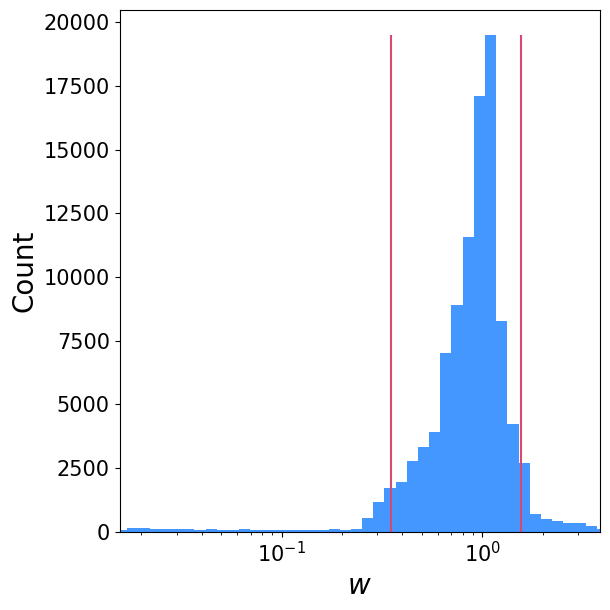

/tmp/ipykernel_32010/2166798665.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x_lower[:,0].cpu().numpy(),x_lower[:,1].cpu().numpy(),s=1,label="overrepresented w<{:.2f}".format(lower),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))
/tmp/ipykernel_32010/2166798665.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x_upper[:,0].cpu().numpy(),x_upper[:,1].cpu().numpy(),s=1, label="underrepresented w>{:.2f}".format(upper),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))


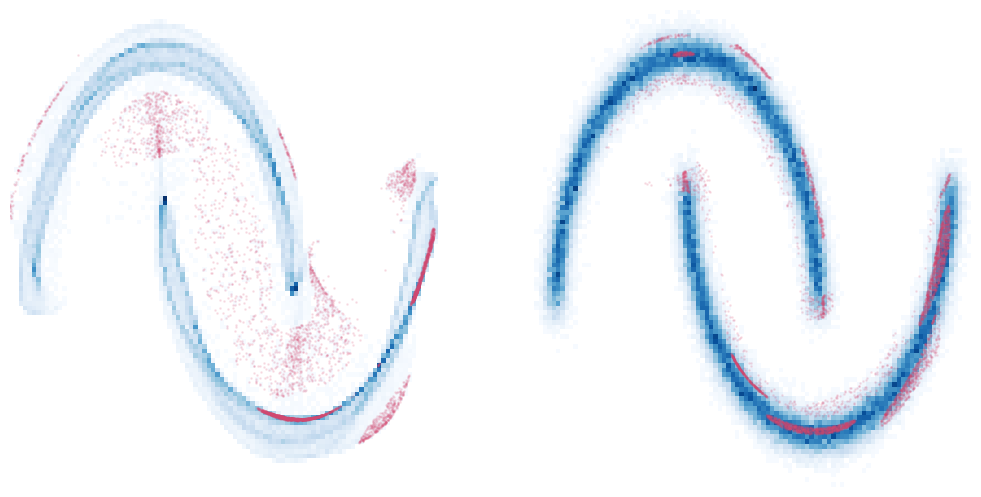

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


0.692543625831604
0.6930862069129944


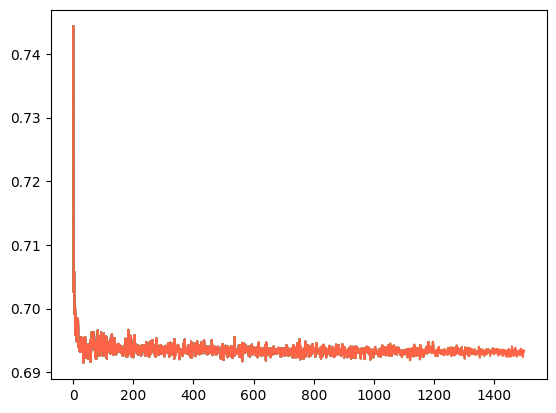

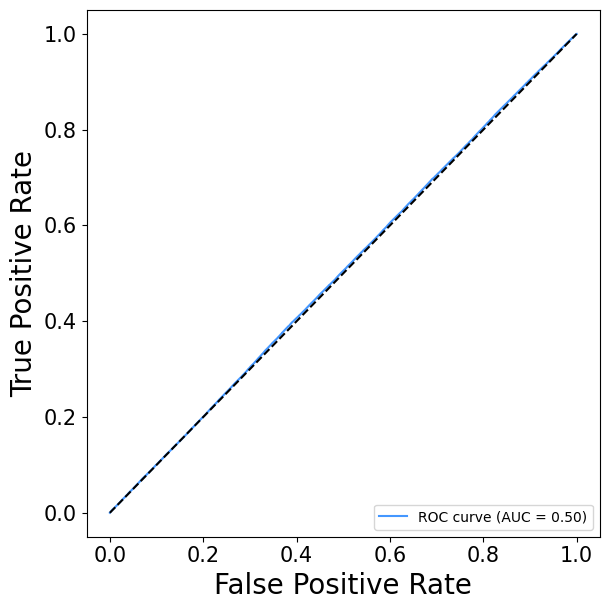

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


tensor(0.9505, device='cuda:0') tensor(1.0693, device='cuda:0')


/tmp/ipykernel_32010/2166798665.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(lower.item(),0,max(n),label="lower",color=plt.cm.get_cmap()(0.1))
/tmp/ipykernel_32010/2166798665.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.vlines(upper.item(),0,max(n),label="upper",color=plt.cm.get_cmap()(0.1))


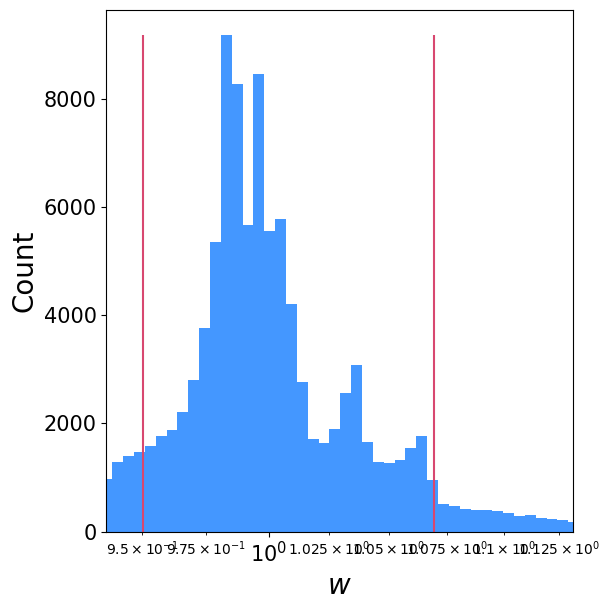

/tmp/ipykernel_32010/2166798665.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x_lower[:,0].cpu().numpy(),x_lower[:,1].cpu().numpy(),s=1,label="overrepresented w<{:.2f}".format(lower),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))
/tmp/ipykernel_32010/2166798665.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x_upper[:,0].cpu().numpy(),x_upper[:,1].cpu().numpy(),s=1, label="underrepresented w>{:.2f}".format(upper),color=plt.cm.get_cmap()(0.1),alpha=1/np.log(len(x_upper)))


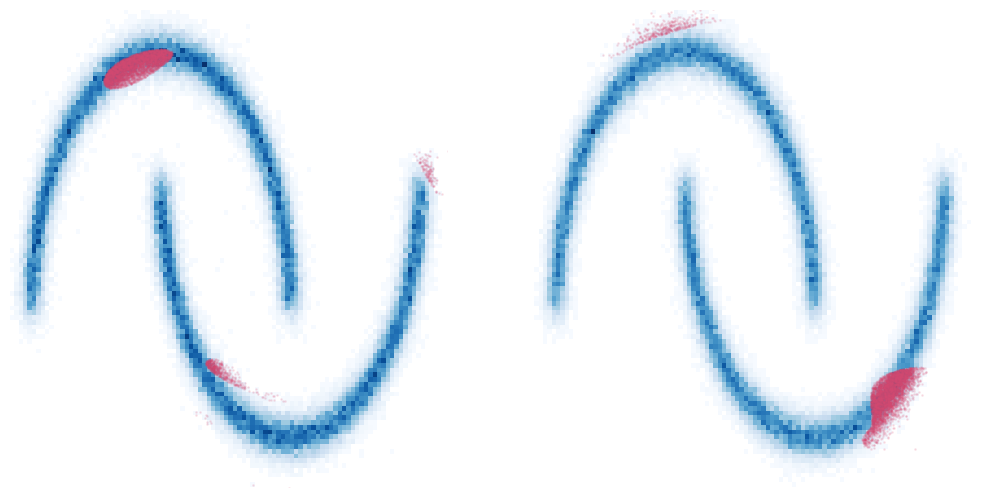

Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field does n

In [14]:
for model,name in zip(models,names):
    train_and_eval_classifier(model,name)